#Data Madness - Wallstreet Bets vs. The World

Authors: 
Trevina Litchmore i6182825
Spriha Joshi i6180416
Tim Dick i6112326

##Introduction
In the month of January 2021 the Game Stop stock price elicited a large bump. This observation can be attributed to a manipulation scheme that was mostly driven by amateur investors and planned on the subreddit wallstreetbets of the social networking platform reddit.com. The hereby documented Data Madness project aimed to investigate the social dynamics behind this manipulation scheme. A ring-leader of the Gamestop stock price manipulation scheme is known by the pseudonym DFV (https://www.boston.com/news/local-news/2021/02/18/keith-gill-roaring-kitty-gamestop-congress). The first question asked whether an actor's popularity in the wallstreetbets subreddit community correlates with the sudden Game Stop stock rise. The second question asked whether the social dynamics of the wallstreetbets subreddit discussion on GME were driven by a few popular actors or rather by the entire community. Lastly, the analysis aimed to identify other stocks that receive increasing attention from the wallstreetbets community.

###Stakeholders
Within the scope of the educational setting the primary stakeholders of this analysis are the authors themselves who aim to grow their data analysis skills. In particular, the goal of this assignment is to learn how to download, preprocess, explore and analyse realistic data sets. The secondary stakeholders are the author's peers who can learn from the project. A tertiary stakeholder is the Institute of Datascience in Maastricht which benefits from preparing its students for the data science job market. Outside the scope of the educational setting the primary stakeholders are the owners of stocks who loose their investments as a consequence of organized misconduct. Secondary stakeholders are legislators who can adjust rules and regulations of the financial market to account for this form of organized stock price manipulation. Lastly, a tertiary stakeholder is the platform Reddit.com which can learn to detect the planning of collective action that harms other people's finance. 

###Ethical Considerations
As this analysis is concerned with the social behaviour of real people it is worth considering its ethical aspects. One might argue that the users of the Reddit community are aware that their posts are submitted to public discussions that everyone can read or write to. Yet there is a difference between a human reading through some discussions and a rigorous analysis processing large numbers of posts. The insights gained from the analysis might surpass the expectations of the user who submits a post to the discussion forum. Yet, Reddit.com uses pseudonyms to conceil user's identity and prevent extraneous parties from identifying the real person behind a post. Apart from that, the here documented analysis confines itself to posts available for download and ignores those of users who have decided to delete their accounts in the meantime. With the exception of the user DFV who publicly declared his identity (https://www.boston.com/news/local-news/2021/02/18/keith-gill-roaring-kitty-gamestop-congress) the hereby executed analysis thus obeys the user's right to stay anonymous during the analysis.

##Methods
###Question: How large is the impact of the most popular wallstreetbets subreddit actors on the remaining community when it comes to discussions on the GME stock price ?
To answer this question a Markov Model for opinion dynamics proposed by Diao et al. (2014) was implemented. This model relies on a social network representation $G(V,E)$ where actors are represented by nodes $v \in V$ and their interactions by arcs $e \in E$. Note that interactions can be directed and multiple arcs between the same pair of nodes are possible. For a given day $t$ the model describes an actor's verbal action towards a certain topic by a state $X \in \{'supporting','opposing'\}$. Here, verbal action was determined by classiying that actor's sentiment for all their posts during day $t$ with the help of natural language tool kit (https://www.nltk.org). The method maintains a variable $Odd_S \in (0,\infty)$ which models the person's latent opinion towards supporting behaviour. $Odd_S$ is updated at every time step by randomly sampling $N_{px}$ persuaders from the set of nodes $V$. $N_{pS}$ is the number of persuaders who elicited a positive sentiment at day $t$ and vice versa for $N_{pO}$. The social influence of a persuader on a target individual is then scaled by their proximity in the social network (shortest path between them). Influences of supportive and opposing persuaders are are then used to update the target individual's $Odd_S$ and hence their predicted verbal action for the next time point $t+1$. Values of $Odd_S$ in the interval $(0,0.5)$ predict an actor's verbal behaviour to be opposing while values above $0.5$ predict supportive behaviour. Here, a large part of the community elicited neutral sentiment and hence Diao et al.'s model was adjusted to predict neutral behaviour when $Odd_S$ was within a small margin around 0.5 (detailed below). 
The model can thus be used to predict the sentiment of each actor towards the discussions on the GME subreddit. As a baseline a random model was used that would predict arbitrary actions. Two experimental conditions were compared, one of which included the most popular actors and one which excluded them. Popularity was determined by a node's degree.   

References:
 * Diao, S. M., Liu, Y., Zeng, Q. A., Luo, G. X., & Xiong, F. (2014). A novel opinion dynamics model based on expanded observation ranges and individuals’ social influences in social networks. Physica A: Statistical Mechanics and its Applications, 415, 220-228.

In [ ]:
! pip install networkx

In [ ]:
import requests, matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from random import randint
import requests, json, time, datetime
import os, sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Configuration
after_date = '23/12/2020'; before_date = '25/12/2020'; subreddit='wallstreetbets'; query = 'GME'; size = 500
drive_path = '/content/drive/MyDrive/reddit posts/'
def make_path(drive_path, size, subreddit, query, after_date, before_date):
  return drive_path + f"<={size} reddit submissions from {subreddit} for query {query} after {after_date.replace('/','-')} before {before_date.replace('/','-')}/"
path = make_path(drive_path, size, subreddit, query, after_date, before_date)

# Scraping Reddit Discussions

In order to answer the three research questions discussions containing the GME keyword were scraped from reddit. Initially, the discussions of one day per week (Friday) were downloaded for 3 months surrounding the stock price bump (13-11-2020 until 12-2-2021). The first research question was answered by analyzing discussion on a more fine-grained temporal resolution to improve the predictive power of the model. For this purpose the 7 days in between 19-12-2020 and 25-12-2020 were selected since their discussions showed highest participation by the community. The data was downloaded by the authors themselves via the pushshift API (https://github.com/pushshift/api).

In [ ]:
os.makedirs(os.path.dirname(path), exist_ok=True)

In [ ]:
def search_submissions(after, before, subreddit, query, fields, size):
  after  = str((int)(time.mktime(datetime.datetime.strptime(after , "%d/%m/%Y").timetuple()))) 
  before = str((int)(time.mktime(datetime.datetime.strptime(before, "%d/%m/%Y").timetuple())))
  result = requests.get("https://api.pushshift.io/reddit/search/submission/?q="+query+"&subreddit="+subreddit+"&before="+before+"&after="+after+"&size="+str(size)+"&fields="+','.join(fields))
  if not result.status_code==200:
    print('Unable to perform request with status code: ' + str(result.status_code))
    return pd.DataFrame(columns=fields)
  else: 
    return pd.DataFrame(json.loads(result.text)['data'])
  
def clean_data_frame(df):
  return df[(df['author'] != '[deleted]') & (df['author'] != 'AutoModerator')].copy()

In [ ]:
submission_fields = ['author','author_fullname','created_utc','id','removed_by_category','score','selftext','upvote_ratio']
submissions_df = search_submissions(after=after_date, before=before_date, subreddit=subreddit, query=query, fields=submission_fields, size=size)
submissions_df = clean_data_frame(submissions_df)
submissions_df.to_excel(path+'Submissions.xlsx')
submissions_df

In [ ]:
def fetch_comments(submission_id, fields):
  result = requests.get("https://api.pushshift.io/reddit/submission/comment_ids/"+submission_id)
  if not result.status_code==200:
    print('Unable to perform request with status code: ' + str(result.status_code))
    return pd.DataFrame(columns=fields)
  else:
    comment_ids = json.loads(result.text)['data']
    result = requests.get("https://api.pushshift.io/reddit/comment/search?ids="+','.join(comment_ids)+"&fields="+','.join(fields)+"&size="+str(min(len(comment_ids),500)))
    if not result.status_code==200:
      print('Unable to perform request with status code: ' + str(result.status_code))
      return pd.DataFrame(columns=fields)
    else:
      result = json.loads(result.text)['data']
      if result == []: return pd.DataFrame(columns=fields)
      else: return pd.DataFrame(result)

In [ ]:
comment_fields = ['author','author_fullname','body','created_utc','id','link_id','score','parent_id','subreddit','subreddit_id']
comments_df = fetch_comments(submission_id=submissions_df.iloc[2]['id'], fields=comment_fields)
comments_df

In [ ]:
def update_user_graph(submission, comments_df, g):
  '''For each comment an arc is drawn from the author of the submission to the author of the comment. 
  Within the comments, consider commenter A and commenter B such that B comments on A. Then the author an arc is drawn from author of A to author of B.'''
  comments_df['parent_id'] = comments_df['parent_id'].map(lambda x: x[3:])
    
  for c, comment in comments_df.iterrows():
    # Add edge from submission author to each commenter
    g.add_edge(submission['author'], comment['author'])
    
    # Optionally add edges within commenters
    current_parent_id = comment['parent_id']
    while not current_parent_id == submission['id']:
      parent_df = comments_df[comments_df['id'] == current_parent_id]
      if not len(parent_df) == 1: 
        print(f"there are {len(parent_df)} parents with id {current_parent_id} for comment with id {comment.id} on submission with id {submission.id}")
        break
      else:
        parent = parent_df.iloc[0]
        g.add_edge(parent['author'], comment['author'])
        current_parent_id = parent['parent_id']   

In [ ]:
g = nx.MultiDiGraph()
for s in range(len(submissions_df)):
  if s % 10 == 0: print(f"fetching comments for submission {s}")
  comments_df = fetch_comments(submission_id=submissions_df.iloc[s]['id'], fields=comment_fields)
  comments_df = comments_df.applymap(lambda x: x.encode('unicode_escape').decode('utf-8') if isinstance(x, str) else x)
  comments_df.to_excel(path + 'Comments on submission ' + str(submissions_df.iloc[s]['id']) + '.xlsx')
  update_user_graph(submissions_df.iloc[s].copy(), clean_data_frame(comments_df), g)

nx.write_gpickle(g, path+'Network.pickle')

fetching comments for submission 0
there are 0 parents with id ggrg1pc for comment with id ggrgicm on submission with id kiht0p
there are 0 parents with id ggrg1pc for comment with id ggrgk58 on submission with id kiht0p
fetching comments for submission 10
there are 0 parents with id ggtjijp for comment with id ggtsvmr on submission with id kil4wu
there are 0 parents with id ggtx738 for comment with id ggtxbaf on submission with id kil4wu
there are 0 parents with id ggu1jqh for comment with id ggu1qzz on submission with id kil4wu
there are 0 parents with id ggu1jqh for comment with id ggu21z2 on submission with id kil4wu
fetching comments for submission 20
fetching comments for submission 30
fetching comments for submission 40
fetching comments for submission 50
fetching comments for submission 60
fetching comments for submission 70
fetching comments for submission 80
fetching comments for submission 90


In [ ]:
g = nx.read_gpickle(path + 'Network.pickle')
d_in = dict(g.in_degree()); max_in = max(d_in.values())
d_out = dict(g.out_degree())
nx.draw(g, edge_color=(0.8,0.8,0.8), nodelist=list(d_in.keys()), node_size=[v*5+10 for v in d_out.values()], node_color=[(v/max_in,0, 1 -v/max_in) for v in d_in.values()])
plt.savefig(path+'Network.png')

In [ ]:
! pip install twython

In [ ]:
import nltk; nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import networkx as nx, matplotlib.pyplot as plt
import os, pandas as pd, random as rd, numpy as np

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def compute_received_social_influence(g, N_p_o, N_p_s, individual_i_name, max_distance=5, min_degree_for_tabu=10^9, use_target=True):
  '''Computes the social influence on individual i. The value x in (A,B) is the orientation of an individual\'s outer actions. The persuaders in d_i and influences are assumed to be the same.
  Inputs:
    g: nx.MultiDiGraph representing the social network.
    N_p_o, N_p_s: int upper bound for the number of opposing and supporting persuaders.
    individual_i_name: str the name of the receiving individual.
    max_distance: int the maximum distance of persuaders from individual i
    min_degree_for_tabu: int indicating the minimum degree a node needs to have in order to be not selected as persuader.
    use_target: bool indicating whether a target individual shoudl persuade itself.
  Outputs:
    SI_i: float indicating the overall social influence received by individual i to engage in the action.'''
  tabu_names = set()
  for name, degree in dict(g.degree).items():
    if degree >= min_degree_for_tabu: tabu_names.add(name)
  supporting_names, opposing_names = search_random_persuaders(g=g, N_p_o=N_p_o, N_p_s=N_p_s, target_name=individual_i_name, max_distance=max_distance, tabu_names=tabu_names, use_target=use_target)
  
  supporting_influences = compute_eliciting_social_influence(g=g, persuader_names=supporting_names)
  supporting_distances = get_shortest_distances(g=g, persuader_names=supporting_names, target_individual_name=individual_i_name)
  SI_i_s = (N_p_s ** 0.5) * np.sum([supporting_influences[name_j] / ((supporting_distances[name_j]+1) ** 2) for name_j in supporting_influences.keys()])

  opposing_influences = compute_eliciting_social_influence(g=g, persuader_names=opposing_names)
  opposing_distances = get_shortest_distances(g=g, persuader_names=opposing_names, target_individual_name=individual_i_name)
  SI_i_o = (N_p_s ** 0.5) * np.sum([opposing_influences[name_j] / ((opposing_distances[name_j]+1) ** 2) for name_j in opposing_influences.keys()])
  
  return SI_i_s, SI_i_o

def compute_eliciting_social_influence(g, persuader_names):
  '''Computes the social influence each individual elicits by taking the square root of their out degree and multiplying it with -1, 0 or 1 depending on whether they act opposing, neutral or supporting, respectively.
  Inputs:
    g: networkx.MultiDiGraph for the social network o finterest.
    persuader_names: [str] collecting the names of people whose influence needs to be calculated.
  Outputs:
    social_influences: dict(str, float) providing the elicited social influence for each persuader.'''
  social_influences = dict.fromkeys(persuader_names)
  for persuader_name in persuader_names:
    social_influences[persuader_name] = g.out_degree(persuader_name) ** 0.5

  return social_influences

def update_odd_A(odd_A_n, SI_A_n, SI_B_n):
  '''Computes the odds for action A at time point n+1 for a given individual.
  Inputs:
    odd_A_n: float indicating the odds for action A of the given individual at time point n.
    SI_A_n, SI_B_n: float the social influence excerted on the given individual to perform action A or B at time n.
  Outputs:
    odd_A_n_plus_1: float indicating the odds for action A at time point n+1.'''
  numerator = 1 + SI_A_n / (SI_A_n + SI_B_n + 1e-5); denominator = 1 + SI_B_n / (SI_A_n + SI_B_n + 1e-5)
  odd_A_n_plus_1 = odd_A_n *  numerator / denominator
  return odd_A_n_plus_1

def update_influence_j(inf_j_n, colleague_influences_n, d_i, d_i_j, delta=1e-3):
  '''Updates the influence that person j has assuming that belongs to a group of persuaders who successfully influenced a target individual.
  Inputs: 
    inj_j_n: float the influence that individual j has at time point n.
    colleague_influences_n: [float] the influences that the other persuadors have on the affected individual at time n.
    d_i: [float] the distances between affected individual i and the here considered persuaders. Indexing is assumes to be synchronous with colleague_influences_n.
    d_i_j: float the distance between persuader j and affected individual i at time n (also contained in d_i).  
    delta: float an update rate
  Outputs:
    inf_j_n_plus_1: float the new social influence of individual j.'''
  numerator = inf_j_n / (d_i_j**2)
  denominator = np.sum([colleague_influences[k] / (d_i[k]**2) for k in range(len(d_i))])
  inj_j_n_plus_1 = inj_j_n + delta * numerator / denominator

def get_shortest_distances(g, persuader_names, target_individual_name, default_distance=5):
  '''Gets the shortest distances between persuaders and target individual in graph G.'''
  di = dict.fromkeys(persuader_names)
  for persuader_name in persuader_names:
    try:
      di[persuader_name] = nx.shortest_path_length(g, source=persuader_name, target=target_individual_name)
    except:
      di[persuader_name] = default_distance
  
  return di
    

def load_attributed_graph(before_date, data_folder):
  '''Loads the social graph whose data is identified by the before date and adds attributes to it.
  Inputs:
    before_date: str in format d-m-y indicating the day after which the data was downloaded.
  Outputs:
    g: networkx.DiMultiGraph with node attributes for action (opposing, neutral, supporting) indicating action judged by overall sentiment of their posts. Nodes with non-neutral sentiment also have attributes total_positive_sentiment and total_negative sentiment.
    action_counts: dict(str:int) indicating how many individuals were supporting, neutral or opposing'''
  
  directories = os.listdir(data_folder)
  for directory in directories:
    if before_date in directory: break
    elif directories == directories[-1]: print(f"Network for before date {before_date} could not be found")

  # Load the graph for the current directory
  g = nx.read_gpickle(data_folder + directory + '/Network.pickle');

  # Atribute action orientation to each individual using sentiments of their posts
  model = SentimentIntensityAnalyzer()

  # Iterate submissions
  submissions_df = pd.read_excel(data_folder + directory + '/Submissions.xlsx')
  for s, submission in submissions_df.iterrows():
    # Retrieve comments
    if 'Comments on submission ' + str(submission.id) + '.xlsx' in os.listdir(data_folder + directory):
      comments_df = pd.read_excel(data_folder + directory + '/Comments on submission ' + str(submission.id) + '.xlsx')
      for c, comment in comments_df.iterrows():
        if not (comment.author == '[deleted]' or comment.author == 'AutoModerator') :
          # Update sentiment counts for author of comment
          sentiment = model.polarity_scores(comment.body)
          node_attributes = g.nodes[comment['author']]
          if not 'total_positive_sentiment' in node_attributes.keys(): nx.set_node_attributes(g, {comment['author']:{'total_positive_sentiment':0.0}})
          if not 'total_negative_sentiment' in node_attributes.keys(): nx.set_node_attributes(g, {comment['author']:{'total_negative_sentiment':0.0}})
          
          pos = node_attributes['total_positive_sentiment'] + sentiment['pos']
          neg = node_attributes['total_negative_sentiment'] + sentiment['neg']
          
          nx.set_node_attributes(g, {comment['author']:{'total_positive_sentiment': pos, 'total_negative_sentiment':neg}})

  # Code action for each individual in graph
  action_counts = {'opposing':0, 'neutral':0, 'supporting':0}
  for individual_name in g.nodes.keys():
    action = 'neutral'
    if 'total_positive_sentiment' in g.nodes[individual_name].keys() and 'total_negative_sentiment' in g.nodes[individual_name].keys():
      if g.nodes[individual_name]['total_positive_sentiment'] > g.nodes[individual_name]['total_negative_sentiment']: action = 'supporting'
      elif g.nodes[individual_name]['total_positive_sentiment'] < g.nodes[individual_name]['total_negative_sentiment']: action = 'opposing'
      
    nx.set_node_attributes(g, {individual_name:{'action': action}})
    action_counts[action] += 1
    
  return g, action_counts

def search_random_persuaders(g, target_name, N_p_o, N_p_s, max_distance, tabu_names, use_target):
  '''Searches a random subset of persuaders in the incoming neighbors of an individual in social graph G.
  Inputs:
    g: networkx graph object with nodes for individuals. Each node needs to have an attribute odds_A indicating their odds for eliciting action A.
    target_name: str the name of the individual who should receive input.
    N_p_o, N_p_s: int indicating the maximum number of opponents (N_p_o) and supporters (N_p_s). This bound is reached when G has enough persuaders.
    max_distance: int maximum distance of neighbors from target node. 
    tabu_names: [str] listing the names of persuaders who may not be selected.
    use_target: bool indicating whether a target individual should persuade itself.
  Outputs:
    supporting_names, opposing_names: [str] collecting the names of selected persuaders.'''

  # Collect neighbors
  if target_name in g.nodes.keys():
    neighbors = set()
    if use_target: neighbors.add(target_name)
    for d in range(max_distance):
      for neighbor in neighbors:
        neighbors = neighbors.union(set([edge[0] for edge in g.in_edges(neighbor)]))
  else:
    neighbors = set(rd.sample(g.nodes.keys(), k=2*(N_p_o+N_p_s)))

  # Select supporting and opposing neighbors
  supporting_names = []
  opposing_names = []
  for neighbor in neighbors:
    if len(supporting_names) < N_p_s and (not neighbor in tabu_names) and g.nodes[neighbor]['action'] == 'supporting': supporting_names.append(neighbor)
    elif len(opposing_names) < N_p_o and (not neighbor in tabu_names) and g.nodes[neighbor]['action'] == 'opposing': opposing_names.append(neighbor)
  
  return supporting_names, opposing_names

def update_previous_odds(previous_odds, previous_graph, individual_name, use_target):
  if not use_target: # The target individual may not influence itself, so it's odds for the previous time frame are set to elicit neutral action
    previous_odds[individual_name] = 0.5 
    return previous_odds

  if previous_graph.nodes[individual_name]['action'] == 'supporting':
    previous_odds[individual_name] = 1.0
  elif previous_graph.nodes[individual_name]['action'] == 'opposing':
    previous_odds[individual_name] = 0.25
  else: previous_odds[individual_name] = 0.5
  return previous_odds

def update_class_counts(actual_action, predicted_action, true_supporters, true_opponents, true_neutrals, false_supporters, false_opponents, false_neutrals):
  if actual_action == 'supporting' and predicted_action == 'supporting': true_supporters[-1]  += 1
  elif actual_action == 'opposing' and predicted_action == 'opposing':   true_opponents[-1]   += 1
  elif actual_action == 'neutral' and predicted_action == 'neutral': true_neutrals[-1] += 1

  elif not actual_action == 'opposing' and predicted_action == 'opposing': false_opponents[-1] += 1
  elif not actual_action == 'supporting' and predicted_action == 'supporting': false_supporters[-1]  += 1
  elif not actual_action == 'neutral' and predicted_action == 'neutral': false_neutrals[-1] += 1
  return true_supporters, true_opponents, true_neutrals, false_supporters, false_opponents, false_neutrals

#Results
##Exploratory Data Analysis - Social Network
The social network graph was found to elicit scale-free properties that are common in real networks. According to chapter 3 of the Network Science book by Barabasi (http://networksciencebook.com/chapter/2%23degree) scale free networks have a degree distribution across nodes that appears similar regardless of how far one zooms into the network. The below diagram is a real network graph from the wallstreets bets subreddit for all users who participated in discussion on the GME stock. When a user published a post and other users responded to this post one has a certificate that they read his/ her post. This is indicated in the network graph by a directed arc from that first user to all correspondents. The below diagram shows users with low out-degree with a small node and users with with a large out-degree with a large node. It shows in blue that users that have a low in-degree and in red the ones that have a large in-degree. One can see that there are many small nodes, several medium-sized nodes and very few large nodes. This corresponds with the scale-free property. The same holds for indegree in that one sees many blue, some pruple and very few red nodes.

Node size increases with out-degree
Node color ranges from blue (low) to red (high) in-degree


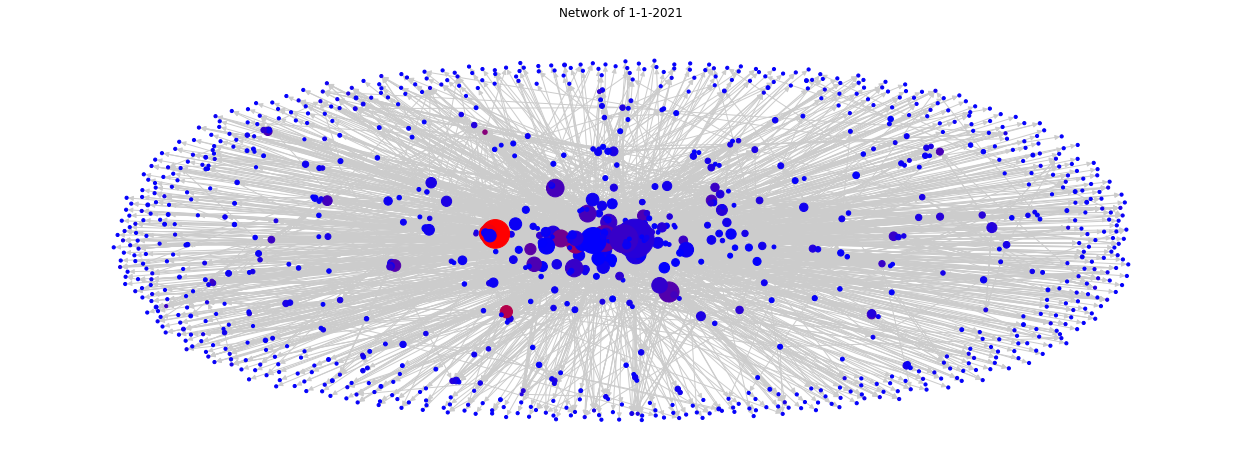

In [ ]:
plt.figure(figsize=(22,8))
g = nx.read_gpickle(make_path(drive_path, size, subreddit, query, after_date='31-12-2020', before_date='2-1-2021') + 'Network.pickle')
d_in = dict(g.in_degree()); max_in = max(d_in.values())
d_out = dict(g.out_degree())
plt.title('Network of 1-1-2021')
nx.draw(g, edge_color=(0.8,0.8,0.8), nodelist=list(d_in.keys()), node_size=[v*5+10 for v in d_out.values()], node_color=[(v/max_in,0, 1 -v/max_in) for v in d_in.values()])
print('Node size increases with out-degree\nNode color ranges from blue (low) to red (high) in-degree')

The intuition of scale-free networks can be formally verified by inspecting the degree distribution on a log-log histogram. Contrary to random network in which high degree nodes are much less common, a scale-free network has relatively many high-degree nodes (compare chapter 4 of the network science book). Its histogram should approximate a triangle which (due to its constant slope) appears to be the same, regardless of how far one zooms in. The social network explored here has the below histograms for in-degree, out-degree and betweenness centrality aggragated over the three months of weekly samples. Although the histograms are not perfectly triangular they match a scale-free network closer that a random network. Regarding the betweenness-centrality on can further observe that there are a few individual with large and 1 with extraordinarily large centraltiy. Hence, these individuals are on the shortest path connecting a large number of pairs of other nodes. One can thus conclude that the social structure in the wallstreet bets subreddit community concerned with the GME stock has a hierarchical structure in which there are a few highly influential actors, some medium influential actors and a large majority of actors who resonate with the leaders.

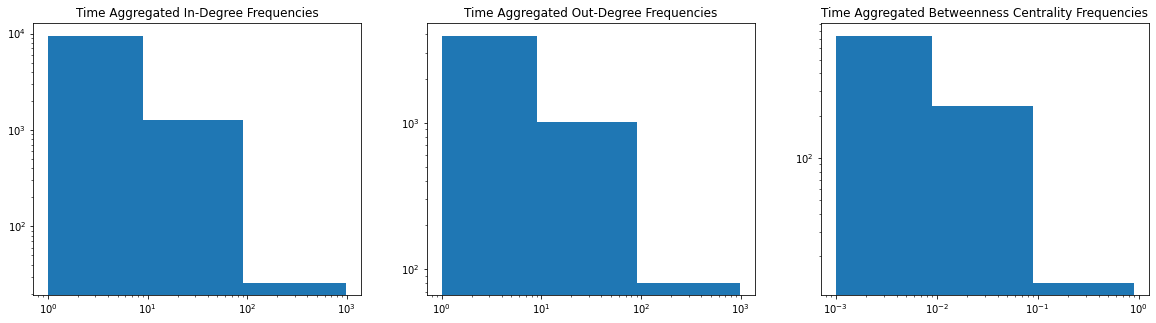

In [ ]:
# These before_dates are for a three month simulation with 1-day-per-week samples
before_dates = ['14-11-2020','21-11-2020','28-11-2020','5-12-2020','12-12-2020','19-12-2020','26-12-2020','2-1-2021','9-1-2021','16-1-2021','23-1-2021','30-1-2021','6-2-2021']#,'13-2-2021']

in_degrees, out_degrees, betweenness_centralities, action_counts = [], [] ,[], [None] * len(before_dates)

plt.figure(figsize=(20,5)); 
for b, before_date in enumerate(before_dates):
  g, action_counts[b] = load_attributed_graph(before_date=before_date, data_folder=drive_path) 
  in_degrees += dict(g.in_degree).values(); out_degrees += dict(g.out_degree).values(); betweenness_centralities += dict(nx.betweenness_centrality(nx.DiGraph(g))).values()

plt.figure(figsize=(20,5)); 
plt.subplot(1,3,1); plt.title('Time Aggregated In-Degree Frequencies')
plt.hist(in_degrees, bins=[1,9,90,990]); plt.yscale('log'); plt.xscale('log')
plt.subplot(1,3,2); plt.title('Time Aggregated Out-Degree Frequencies')
plt.hist(out_degrees, bins=[1,9,90,990]); plt.yscale('log'); plt.xscale('log')
plt.subplot(1,3,3); plt.title('Time Aggregated Betweenness Centrality Frequencies')
plt.hist(betweenness_centralities, bins=[0.001,0.009,0.09,0.9]); plt.yscale('log'); plt.xscale('log')

The next step of the exploratory network analysis focused on the sentiment that actors elicited in their posts. The sentiment was classified using the natural language tool kit. In line with the goal to use Diao et al.'s model for opinion dynamics the below diagram shows the proportion of actors whose sentiment appeared supportive, neutral or opposing with regard to the GME stock discussions. One can see that a positive sentiment is elicited in around half of the posts while neutral or negative sentiment each occupy roughly a quarter of posts. This distribution remains reasonably stable across time. Overall, the number of posts in discussions peek during the christmas holiday break.

                                                             Action frequencies
O: opposing actors
N: neutral actors
S: supporting actors


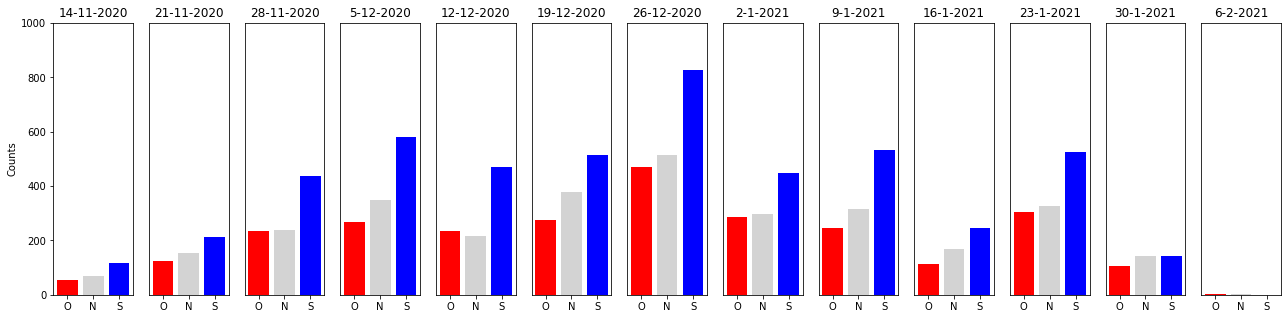

In [ ]:
plt.figure(figsize=(22,5))
for b, before_date in enumerate(before_dates):
  plt.subplot(1, len(before_dates), b+1); plt.title(before_date)
  dic = {'opposing':'O','supporting':'S','neutral':'N'}
  plt.bar([dic[k] for k in action_counts[b].keys()], action_counts[b].values(),color=['red','lightgray','blue']);  plt.ylim((0,1000)); 
  if b == 0: plt.ylabel('Counts')
  else:
    ax = plt.gca(); ax.set_yticks([])
print('                                                             Action frequencies')
print('O: opposing actors\nN: neutral actors\nS: supporting actors')

In [ ]:
def predict(drive_path, run_count, before_dates, min_degree_for_tabu, use_target):
  '''Predict the evolution of actions in the social network.
  Inputs:
    drive_path: str
    run_count: int specifying how many runs the model should perform to obtain confidence intervals aroung its estimates.
    before_dates: [int] listing dates of the form d-m-yyyy that reference the files in the data directory.
    min_degree_for_tabu: int indicating the minimum degree a user needs to have in order to be excldued from the list of persuaders when a person's action is predicted for the next time frame.
    use_target: bool indicating whether a target individual should persuade itself.'''
  all_runs_true_supporters = [None]*run_count; all_runs_true_opponents = [None]*run_count; all_runs_true_neutrals = [None]*run_count; 
  all_runs_false_supporters = [None]*run_count; all_runs_false_opponents = [None]*run_count; all_runs_false_neutrals = [None]*run_count

  baseline_all_runs_true_supporters = [None]*run_count; baseline_all_runs_true_opponents = [None]*run_count; baseline_all_runs_true_neutrals = [None]*run_count; 
  baseline_all_runs_false_supporters = [None]*run_count; baseline_all_runs_false_opponents = [None]*run_count; baseline_all_runs_false_neutrals = [None]*run_count


  for r in range(run_count):
    # Initialze previous social graph
    previous_graph, previous_action_counts = load_attributed_graph(before_date=before_dates[0], data_folder=drive_path)
    previous_odds = {}

    for individual_name in previous_graph.nodes.keys(): previous_odds = update_previous_odds(previous_odds=previous_odds, previous_graph=previous_graph, individual_name=individual_name, use_target=use_target)

    # Initialize classification records
    true_supporters = []; true_opponents = []; true_neutrals = []; false_supporters = []; false_opponents = []; false_neutrals = []
    baseline_true_supporters = []; baseline_true_opponents = []; baseline_true_neutrals = []; baseline_false_supporters = []; baseline_false_opponents = []; baseline_false_neutrals = []
    supporting_counts = [previous_action_counts['supporting']]
    neutral_counts = [previous_action_counts['neutral']]
    opposing_counts = [previous_action_counts['opposing']]

    # Iterate the time points and predict the behaviours

    for before_date in before_dates[1:]:
      # Initialize current classification record
      for counter in [true_supporters, true_opponents, false_supporters, false_opponents, true_neutrals, false_neutrals, baseline_true_supporters, baseline_true_opponents, baseline_false_supporters, baseline_false_opponents, baseline_true_neutrals, baseline_false_neutrals]: counter.append(0)

      # Given the current graph predict the action of each individual
      current_graph, current_action_counts = load_attributed_graph(before_date=before_date, data_folder=drive_path)
      for individual_name in current_graph.nodes.keys():
        eta = 0.5 # controls the width of the region of odds_support that is counted as neutral
        lambda_ = 3.0 # controls the effect of social circles (people preferring to talk to like-minded people)
        # Take into account the clique of the current user
        # Person used to be neutral
        N_p_o = (int)(10 * opposing_counts[-1] / (supporting_counts[-1] + opposing_counts[-1]))
        N_p_s = (int)(10 * supporting_counts[-1] / (supporting_counts[-1] + opposing_counts[-1])) 
        
        if not individual_name in previous_odds.keys():
          previous_odds[individual_name] = 0.5 # Person starts out as neutral
        if np.log(2.0*previous_odds[individual_name]) > eta: # Person used to be a supporter
          N_p_o = (int)(10 * opposing_counts[-1] / (lambda_ * supporting_counts[-1] + opposing_counts[-1]))
          N_p_s = (int)(10 * lambda_ * supporting_counts[-1] / (lambda_ * supporting_counts[-1] + opposing_counts[-1])) 
        elif np.log(2.0*previous_odds[individual_name]) < -eta : # Person used to be an opponent
          N_p_o = (int)(10 * lambda_ * opposing_counts[-1] / (supporting_counts[-1] + lambda_ * opposing_counts[-1]))
          N_p_s = (int)(10 * supporting_counts[-1] / (supporting_counts[-1] + lambda_ * opposing_counts[-1])) 
        
        # Predict user action
        SI_supporting, SI_opposing = compute_received_social_influence(g=previous_graph, N_p_o=N_p_o, N_p_s=N_p_s, individual_i_name=individual_name, min_degree_for_tabu=min_degree_for_tabu, use_target=use_target)
        predicted_odds_supporting = update_odd_A(odd_A_n=previous_odds[individual_name], SI_A_n=SI_supporting, SI_B_n=SI_opposing)
        
        
        # Update previous action record
        previous_odds[individual_name] = predicted_odds_supporting
        
        # Update odds for the next iteration
        previous_odds = update_previous_odds(previous_odds=previous_odds, previous_graph=current_graph, individual_name=individual_name, use_target=use_target)
        
        if eta < np.log(2.0*predicted_odds_supporting):   predicted_action = 'supporting' 
        elif np.log(2.0*predicted_odds_supporting) < -eta: predicted_action = 'opposing'
        else: predicted_action = 'neutral'
        
        # Update records of prediction performance
        actual_action = current_graph.nodes[individual_name]['action']
        true_supporters, true_opponents, true_neutrals, false_supporters, false_opponents, false_neutrals = update_class_counts(actual_action, predicted_action, true_supporters, true_opponents, true_neutrals, false_supporters, false_opponents, false_neutrals)
        baseline_true_supporters, baseline_true_opponents, baseline_true_neutrals, baseline_false_supporters, baseline_false_opponents, baseline_false_neutrals = update_class_counts(actual_action, rd.choice(['neutral','supporting','opposing']), baseline_true_supporters, baseline_true_opponents, baseline_true_neutrals, baseline_false_supporters, baseline_false_opponents, baseline_false_neutrals)

      supporting_counts.append(current_action_counts['supporting']); neutral_counts.append(current_action_counts['neutral']); opposing_counts.append(current_action_counts['opposing'])
      
      # Propagate graph
      previous_graph = current_graph; previous_action_counts = current_action_counts

    # Save results of current run
    all_runs_true_supporters[r] = np.mean(true_supporters); all_runs_true_opponents[r] = np.mean(true_opponents); all_runs_true_neutrals[r] = np.mean(true_neutrals)
    all_runs_false_supporters[r] = np.mean(false_supporters); all_runs_false_opponents[r] = np.mean(false_opponents); all_runs_false_neutrals[r] = np.mean(false_neutrals)
    
    baseline_all_runs_true_supporters[r] = np.mean(baseline_true_supporters); baseline_all_runs_true_opponents[r] = np.mean(baseline_true_opponents); baseline_all_runs_true_neutrals[r] = np.mean(baseline_true_neutrals)
    baseline_all_runs_false_supporters[r] = np.mean(baseline_false_supporters); baseline_all_runs_false_opponents[r] = np.mean(baseline_false_opponents); baseline_all_runs_false_neutrals[r] = np.mean(baseline_false_neutrals)
    
  # Visualize results
  plt.figure(figsize=(30,10))
  plt.subplot(1,3,1); plt.title('Supporting Actors')
  y_error = 3*np.std([[np.mean(supporting_counts)]*run_count, baseline_all_runs_true_supporters, baseline_all_runs_false_supporters], axis=-1)
  plt.errorbar(['Actual','True','False'], np.mean([[np.mean(supporting_counts)]*run_count, baseline_all_runs_true_supporters, baseline_all_runs_false_supporters], axis=-1),yerr=y_error); plt.ylim((0,800))
  y_error = 3*np.std([[np.mean(supporting_counts)]*run_count, all_runs_true_supporters, all_runs_false_supporters], axis=-1)
  plt.bar(['Actual','True','False'], np.mean([[np.mean(supporting_counts)]*run_count, all_runs_true_supporters, all_runs_false_supporters], axis=-1),yerr=y_error,color='lightgray'); plt.ylim((0,800))
  plt.legend(['Random Model','Social Model'])
  plt.ylabel('Count')

  plt.subplot(1,3,2); plt.title('Opposing Actors')
  y_error = 3*np.std([[np.mean(opposing_counts)]*run_count, baseline_all_runs_true_opponents, baseline_all_runs_false_opponents], axis=-1)
  plt.errorbar(['Actual','True','False'], np.mean([[np.mean(opposing_counts)]*run_count, baseline_all_runs_true_opponents, baseline_all_runs_false_opponents], axis=-1), yerr=y_error); plt.ylim((0,800))
  y_error = 3*np.std([[np.mean(opposing_counts)]*run_count, all_runs_true_opponents, all_runs_false_opponents], axis=-1)
  plt.bar(['Actual','True','False'], np.mean([[np.mean(opposing_counts)]*run_count, all_runs_true_opponents, all_runs_false_opponents], axis=-1), yerr=y_error, color='lightgray'); plt.ylim((0,800))
  plt.legend(['Random Model','Social Model'])
  plt.ylabel('Count')

  plt.subplot(1,3,3); plt.title('Neutral Actors')
  y_error = 3*np.std([[np.mean(neutral_counts)]*run_count, baseline_all_runs_true_neutrals, baseline_all_runs_false_neutrals], axis=-1)
  plt.errorbar(['Actual','True','False'], np.mean([[np.mean(neutral_counts)]*run_count, baseline_all_runs_true_neutrals, baseline_all_runs_false_neutrals], axis=-1), yerr=y_error); plt.ylim((0,800))
  y_error = 3*np.std([[np.mean(neutral_counts)]*run_count, all_runs_true_neutrals, all_runs_false_neutrals], axis=-1)
  plt.bar(['Actual','True','False'], np.mean([[np.mean(neutral_counts)]*run_count, all_runs_true_neutrals, all_runs_false_neutrals], axis=-1), yerr=y_error,color='lightgray'); plt.ylim((0,800))
  plt.legend(['Random Model','Social Model'])
  plt.ylabel('Count')

The second research question asked about the effect of the most popular users on the wallstreetsbets subreddit community when it comes to discussions on GME. The model by Diao et al. was used to predict a person's sentiment towards the topic based on their latent opinion. Latent opinion $Odds_S$ was modelled by taking into account the person's previous $Odds_S$ as well as the person's neighbors. The below diagram shows the predicted proportions of people with supporting, neutral and opposing verbal behaviour (sentiment). Each of the three subplots show the actual number of users in this category, the true positives and the false negatives. The gray bars indicate the performance of the model while the blue lines indicate the performance of a random model that merely guesses each person's subsequent verbal action. Error bars are obtained by repeating the analysis $r=10$ times. One can see that the model significantly outperforms the random model. It increases the ratio of true over false predictions for supporting, neutral as well as opposing actors. In order to test whether popular users actually have an effect on the community the analysis was repeated by adding all users with a degree above 100 to a taboo list. Hence, they could not be used by the model to estimate the supporting or opposing social influence on a target individual. It was expected that the model would performs less well in this case. 

Model performance


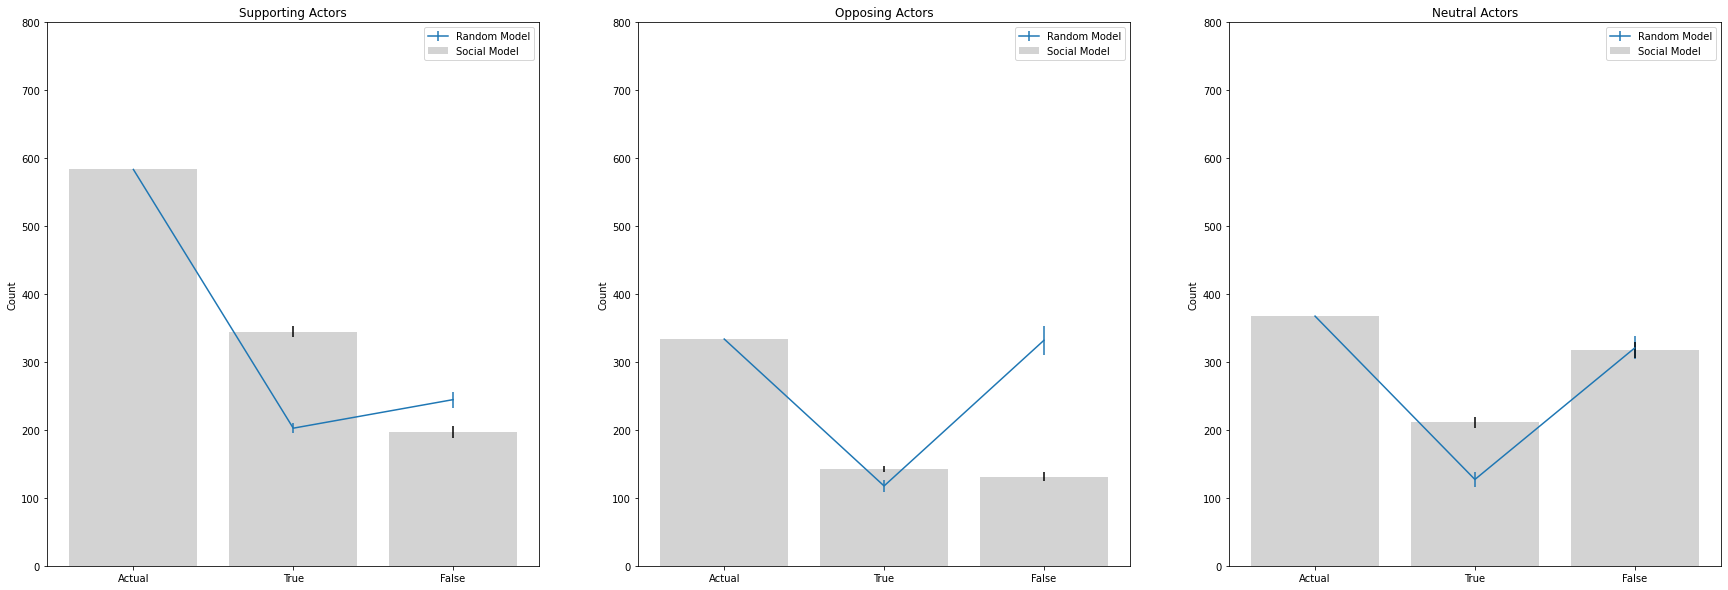

In [ ]:
# These before_dates are for a 1 week simulation with daily samples
before_dates = ['20-12-2020', '21-12-2020', '22-12-2020', '23-12-2020', '24-12-2020', '25-12-2020', '26-12-2020']

# Run the model without adding nodes to the tabu list
predict(drive_path=drive_path, run_count=10, before_dates=before_dates, min_degree_for_tabu=10^9, use_target=True)
print('Model performance')

The below diagram shows the results for the configuration in which popular users were added to the taboo list. One can see that the model still outperforms the random model in that its ratio for true over false predictions are increased for supporters, neutrals and opponents. This finding is surprising and challenges the ratioanle that popular users are responsible for spreading sentiment towards the GME stock price among the wallstreetbets community. An alternative mechansism governing sentiment in the network be the so-called confirmation bias (https://en.wikipedia.org/wiki/Confirmation_bias). This bias described by social osychologists as the tendency to search for information confirming one's existing beliefs. In order to test whether a person's verbal action at day $t$ would predict their action at day $t+1$ the analysis was repeated by preventing a person from persuading itself.

Model performance with tabu list containing users with degree above 100


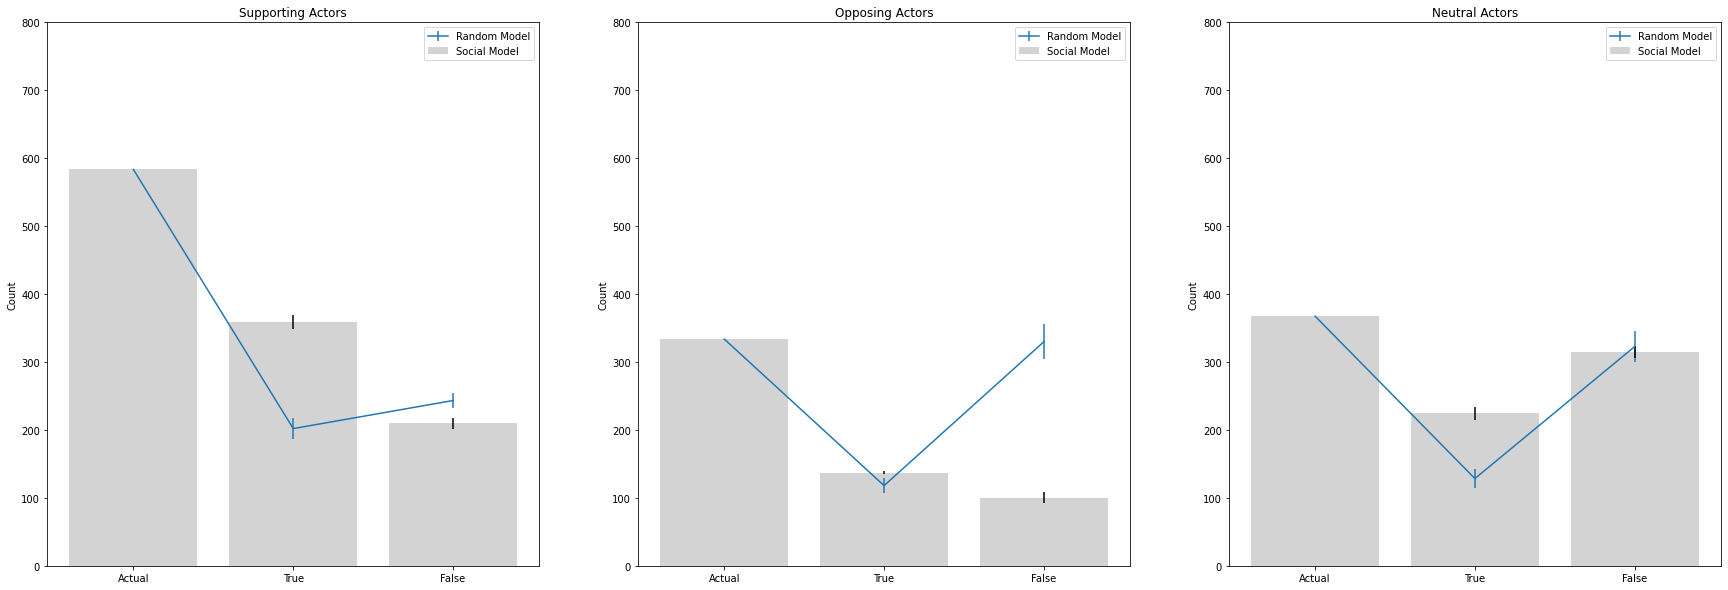

In [ ]:
# Run the model without adding nodes to the tabu list
predict(drive_path=drive_path, run_count=10, before_dates=before_dates, min_degree_for_tabu=10^2, use_target=True)
print('Model performance with tabu list containing users with degree above 100')

The below diagram shows how the model's performance deteriorates when a person is not allowed to persuade itself. One can see immediately than it predicts most people to be neutral. Consequently, there are less predictions for supporting or opposing verbal actions. This finding suggests that popular players in the community are unlikely to change a person's opinion fast, i.e. within one day. Instead, it appears that people maintain their pre-existing beliefs.

Model performance without self-persuasion


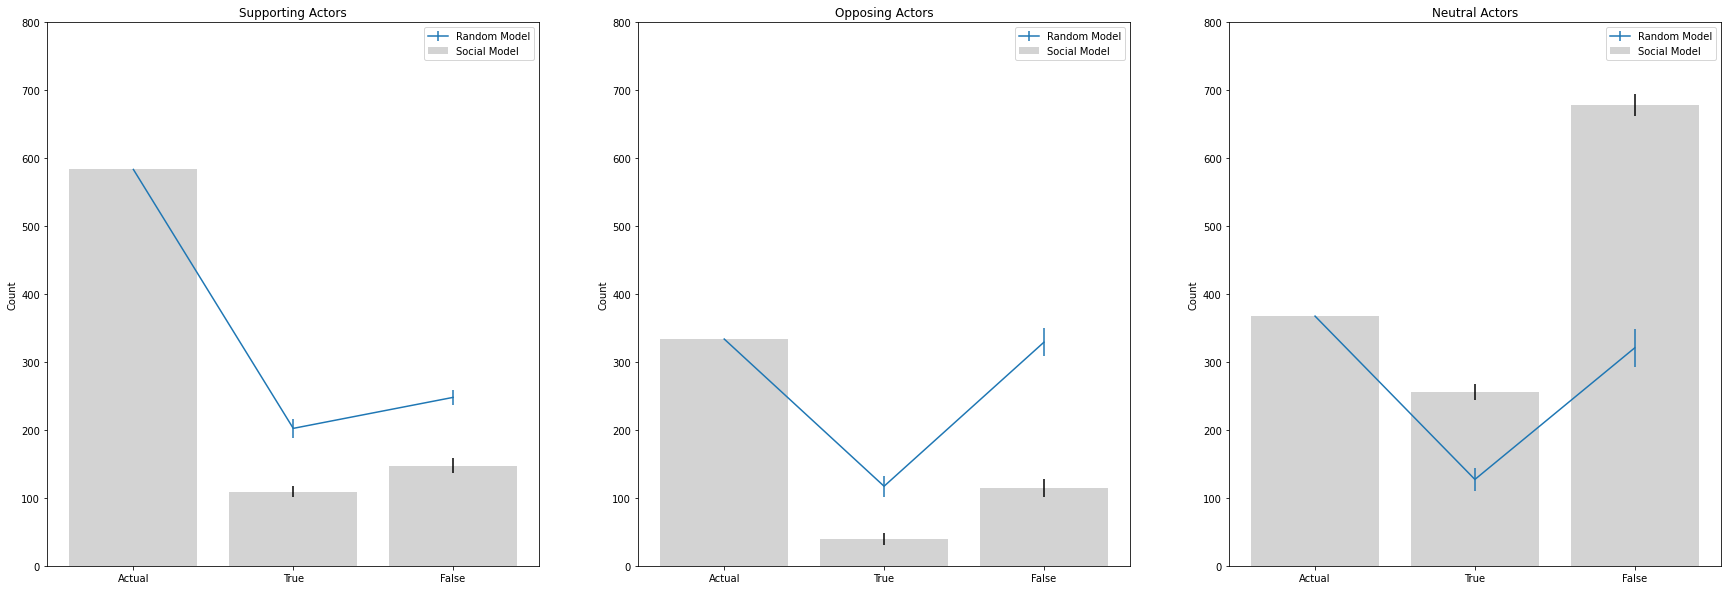

In [ ]:
# Run the model without adding nodes to the tabu list
predict(drive_path=drive_path, run_count=10, before_dates=before_dates, min_degree_for_tabu=10^9, use_target=False)
print('Model performance without self-persuasion')

# Discussion
The second research question asked on the impact of popular users on the sentiment (verbal action) of the remaining wallstreetsbets subreddit community when it comes to discussion on the GME stock price. It used the opinion dynamics model proposed by Diao et al. to predict a person's opinion at day $t+1$ based on their opinion at day $t$ as well as the persuasive influence of its neighbors. As the social network was found to have a scale-free degree distribution its social structure can be described as hierarchical. It was thus expeced that sentiment of popular actors would spread among the crowds. The analyssi revealed that the model outperformed a random model regardless of whether popular users were allowed to persuade others or not. This unexpected finding was put into perspective when the model was configured to ignore a person's opinion at day $t$. In this case the model predicted an overwhelming majority of people to elicit neutral verbal behaviour. This manipulation revealed that a person's opinion is more likely to be affected by itself and less likely to be changed by others, regardless of their popularity. One has to note that the model only considered a person's opinion from the previous day. At this point one might aim to study the dynamics of a person's longterm development. Possibly, the rate of change in a person's ratio of posts with positive to negative sentiment is an even more reliable indicator than their latent opinion at day $t$.